# Training a CNN in Keras with Real-Time Data Augmentation

## Initial Setup

In [1]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Images into a Matrix

In [2]:
base_dir = 'square_images128'
image_width = 128
image_height = 128

classes = ['daffodil',  'snowdrop', 'lily_valley', 'bluebell', 'crocus', 'iris', 
           'tigerlily', 'tulip', 'fritillary', 'sunflower', 'daisy', 'colts_foot', 
           'dandelion', 'cowslip', 'buttercup', 'windflower', 'pansy']

class_dict = { class_name: index for (index, class_name) in enumerate(classes)}

EXTENSIONS = [".jpg", ".bmp", ".png", ".pgm", ".tif", ".tiff"]

folders = os.listdir(base_dir)
folders = [folder for folder in folders if folder != '.DS_Store']

xs = []
ys = []

for folder_name in folders:
    # We look up the class number based on the name of the folder the image is in.
    # This maps a folder name like 'daffodil' to a class number like 0.
    class_index = class_dict[folder_name]
    
    file_names = os.listdir(base_dir + '/' + folder_name)
    #file_names = [name for name in file_names if name != '.DS_Store']
    file_names = [name for name in file_names if os.path.splitext(name)[-1].lower() in EXTENSIONS]
    
    X = np.empty([len(file_names), image_width, image_height, 3])
    y = []
    
    for (index, file_name) in enumerate(file_names):
        file_path = base_dir + '/' + folder_name + '/' + file_name
        #print(file_path)
        I = np.array(Image.open(file_path))
        X[index] = I
        y.append(class_index)
    
    X_combined = X
    y_array = np.array(y)
    xs.append(X_combined)
    ys.append(y_array)
    
    
X_all = np.concatenate(xs)
y_all = np.concatenate(ys)

print(X_all.shape)
print(y_all.shape)

(1360, 128, 128, 3)
(1360,)


In [3]:
# Randomly shuffle the input images and labels (IN THE SAME RANDOM ORDER SO THEY ARE STILL CORRELATED)
rng_state = np.random.get_state()
np.random.shuffle(X_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

In [4]:
# Split the data into training/validation/testing segments
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25)

"""
# 20% of training data reserved for the validation set
# Here we're using a fixed validation set, not doing cross-validation
percentage_validation = 0.20

num_total = X_train.shape[0]
num_validation = int(num_total * percentage_validation)
num_training = num_total - num_validation

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_training points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
"""

"\n# 20% of training data reserved for the validation set\n# Here we're using a fixed validation set, not doing cross-validation\npercentage_validation = 0.20\n\nnum_total = X_train.shape[0]\nnum_validation = int(num_total * percentage_validation)\nnum_training = num_total - num_validation\n\n# Our validation set will be num_validation points from the original training set.\nmask = range(num_training, num_training + num_validation)\nX_val = X_train[mask]\ny_val = y_train[mask]\n\n# Our training set will be the first num_training points from the original training set.\nmask = range(num_training)\nX_train = X_train[mask]\ny_train = y_train[mask]\n"

In [5]:
# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
#X_val -= mean_image
X_test -= mean_image

# Transpose so that channels come first
X_train = X_train.transpose(0, 3, 1, 2).copy()
#X_val = X_val.transpose(0, 3, 1, 2).copy()
X_test = X_test.transpose(0, 3, 1, 2).copy()

print(X_train.shape)
#print(X_val.shape)
print(X_test.shape)

(1020, 3, 128, 128)
(340, 3, 128, 128)


In [6]:
from __future__ import absolute_import
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from six.moves import range

'''
    Train a (fairly simple) deep CNN on the CIFAR10 small images dataset.

    GPU run command:
        THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py

    It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
    (it's still underfitting at that point, though).

    Note: the data was pickled with Python 2, and some encoding issues might prevent you
    from loading it in Python 3. You might have to load it in Python 2,
    save it in a different format, load it in Python 3 and repickle it.
'''

batch_size = 16
num_classes = 17
num_epochs = 30

# input image dimensions
img_rows, img_cols = 128, 128
# the images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print(Y_train[0])


model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='full',
                        input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adadelta)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255


print("Using real time data augmentation")

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

for e in range(num_epochs):
    print('-'*40)
    print('Epoch', e)
    print('-'*40)
    print("Training...")
    # batch train with realtime data augmentation
    progbar = generic_utils.Progbar(X_train.shape[0])
    for X_batch, Y_batch in datagen.flow(X_train, Y_train):
        loss = model.train_on_batch(X_batch, Y_batch)
        progbar.add(X_batch.shape[0], values=[("train loss", loss)])

    print("Testing...")
    # test time!
    progbar = generic_utils.Progbar(X_test.shape[0])
    for X_batch, Y_batch in datagen.flow(X_test, Y_test):
        score = model.test_on_batch(X_batch, Y_batch)
        progbar.add(X_batch.shape[0], values=[("test loss", score)])

X_train shape: (1020, 3, 128, 128)
1020 train samples
340 test samples
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Using real time data augmentation
----------------------------------------
Epoch 0
----------------------------------------
Training...
1020/1020 [==============================] - 43s - train loss: 3.5735    
Testing...
340/340 [==============================] - 11s - test loss: 2.8363    
----------------------------------------
Epoch 1
----------------------------------------
Training...
1020/1020 [==============================] - 43s - train loss: 2.8362    
Testing...
340/340 [==============================] - 11s - test loss: 2.8388    
----------------------------------------
Epoch 2
----------------------------------------
Training...
1020/1020 [==============================] - 42s - train loss: 2.7172    
Testing...
340/340 [==============================] - 11s - test loss: 3.7299    
----------------------------------------
Epoch 3
--

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


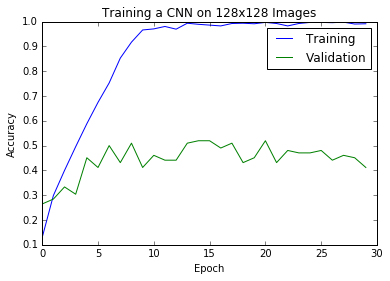

In [9]:
training_accuracies = history.history['acc']
validation_accuracies = history.history['val_acc']

plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training a CNN on 128x128 Images')